# Phosphorus Machine Learning Project

### See `utils.py` for the bones of the code.

### This notebook is exclusively for visualization.

In [1]:
import utils
from utils import *

from importlib import reload
# to reload utils, run:
utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in Data

In [3]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

X_data = get_Data(Listdir)

XANES_energies = X_data[0]['XANES_Spectra'][0]
XES_energies = X_data[0]['XES_Spectra'][0]

### Create dictionary maps for each CID based on different codes

In [4]:
X_data_classed = [c for c in X_data if c['Class']!='None']
compoundmap = {compound['CID']:compound for compound in X_data_classed}

CIDs = np.array([c['CID'] for c in X_data_classed])
NoneCIDs = np.array([c['CID'] for c in X_data if c['Class']=='None'])

make_SI_figures = False

# CLASSSIFICATION MAPS
# classes
classcodemap = {compound['CID']:CLASSCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in CLASSCODES.keys()}
classnames = list(CLASSCODES.keys())[:-1]

# coordination
coordcodemap = {compound['CID']:COORDCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in COORDCODES.keys()}

# sulfur subclasses
sulfurcodemap = {compound['CID']:SULFURCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in SULFURCODES.keys()}

# OH subclasses
ohcodemap = {compound['CID']:OHCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in OHCODES.keys()}

# chargemap
chargemap = {compound['CID']:compound['Charge'] for compound in X_data_classed}

# Cluster Analysis

## PCA

VtC-XES takes 6 PCs to explain 0.9094 variance
XANES takes 12 PCs to explain 0.9095 variance
[0.00045704 0.00045806 0.00045912 0.00046023 0.00046138 0.00046259
 0.00046384 0.00046515 0.00046651 0.00046792 0.00046939 0.00047093
 0.00047252 0.00047417 0.00047589 0.00047767 0.00047952 0.00048144
 0.00048342 0.00048547 0.0004876  0.00048979 0.00049206 0.00049439
 0.0004968  0.00049928 0.00050183 0.00050446 0.00050715 0.00050992
 0.00051276 0.00051566 0.00051864 0.00052168 0.0005248  0.00052798
 0.00053123 0.00053454 0.00053792 0.00054137 0.00054488 0.00054845
 0.00055209 0.00055579 0.00055956 0.00056339 0.00056729 0.00057125
 0.00057528 0.00057937 0.00058353 0.00058775 0.00059205 0.00059641
 0.00060085 0.00060536 0.00060994 0.00061459 0.00061933 0.00062414
 0.00062903 0.00063401 0.00063906 0.00064421 0.00064944 0.00065477
 0.00066019 0.0006657  0.00067132 0.00067703 0.00068285 0.00068878
 0.00069482 0.00070098 0.00070725 0.00071364 0.00072016 0.00072681
 0.00073359 0.0007405  0.00074756 0.

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

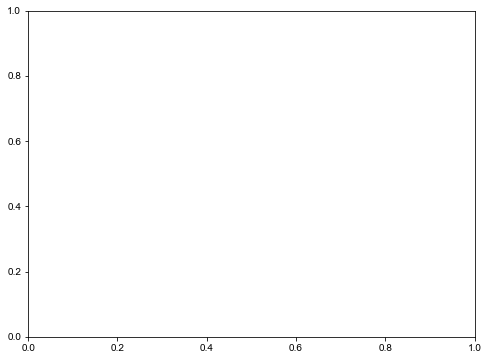

In [22]:
# if make_SI_figures:
if True:
    XES = np.array([c['XES_Normalized'] for c in X_data_classed])
    XANES = np.array([c['XANES_Normalized'] for c in X_data_classed])

    # pca
    pca_all_xes = PCA()
    XES_PCA = pca_all_xes.fit_transform(XES)
    pca_all_xanes = PCA()
    XANES_PCA = pca_all_xanes.fit_transform(XANES)

    N = XANES_PCA.shape[1]

    explained_var_xes = np.array([np.sum(pca_all_xes.explained_variance_ratio_[:i+1]) for i in range(N)])
    explained_var_xanes = np.array([np.sum(pca_all_xanes.explained_variance_ratio_[:i+1]) for i in range(N)])

    threshold_xes = np.where(explained_var_xes >= 0.9)[0][0]
    threshold_xanes = np.where(explained_var_xanes >= 0.9)[0][0]

    print(f"VtC-XES takes {threshold_xes+1} PCs to explain {explained_var_xes[threshold_xes]:.04f} variance")
    print(f"XANES takes {threshold_xanes+1} PCs to explain {explained_var_xanes[threshold_xanes]:.04f} variance")
    
    pca = PCA(n_components=threshold_xes + 1)
    pca = pca.fit(XES)
    true = [XES[0]]
    reduced = pca.transform(true)
    recon = pca.inverse_transform(reduced)
    
    x = X_data_classed[0][f'XES_Spectra'][0]
    fig, ax = plt.subplots(figsize=(8,6))
    true = np.array(true).reshape(-1)
    print(true)
    ax.scatter(x, true, 'r-')
#     plt.plot([x], recon, 'k-')
    plt.show()

#     make_stacked_scree(pca_all_xes.explained_variance_ratio_, pca_all_xanes.explained_variance_ratio_, n=15)

# Coordination

* How does tricoordinate versus tetracoordinate compare?

In [11]:
X_coord, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XES',
                                                             method='UMAP')
X_coord, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XANES',
                                                                 method='UMAP')

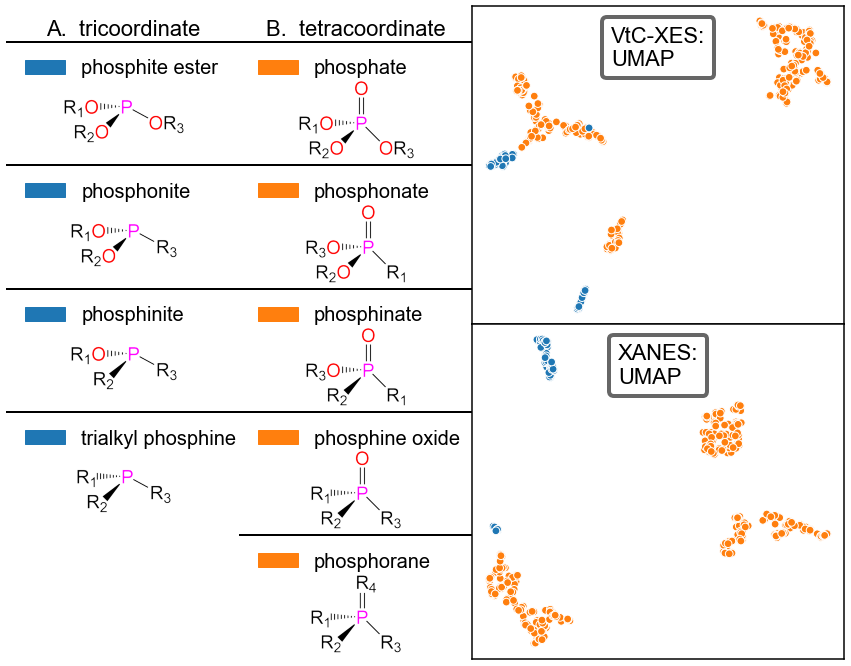

In [10]:
fig = plt.figure(figsize=(15,12))
asize = 0.4
spec = fig.add_gridspec(nrows=11, ncols=3,
                        width_ratios = [0.5, 0.5, 0.8],
                        height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0., hspace=0)

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate', 'B.  tetracoordinate']

colorcode, codemap = COORDCODES, coordcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # show structure
        structax = fig.add_subplot(spec[2*i + 2,j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        plt.axis('equal')
        # Hide spines
        set_spine_width(structax, width=2)
        turn_off_spines(structax, spines=['top','left','right'])
        if i == len(structure_list) - 1:
            structax.spines['bottom'].set_visible(False)
        turn_off_ticks(structax)

        # make legend
        legax = fig.add_subplot(spec[2*i + 1,j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.25),
                              fontsize=20, framealpha=0, frameon=False)
        # Hide spines
        set_spine_width(legax, width=2)
        turn_off_spines(legax, spines=['bottom','left','right'])
        turn_off_ticks(legax)
        
        if i == 0:
            legax.set_title(titles[j], fontsize=22)
            
ax = fig.add_subplot(spec[:6,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                              mode='XES', method='UMAP', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 'upper center'})
set_spine_width(ax, width=1.5)

ax = fig.add_subplot(spec[6:11,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                              mode='XANES', method='UMAP', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 'upper center'})
set_spine_width(ax, width=1.5)

# plt.savefig(f'../Figures/coordination.png', dpi=1000, transparent=False, bbox_inches='tight')

## Oxidation within coordination

* Within tricoordination and tetracoordinate compounds, how does the increase in oxidation state affect the location in the t-SNE reduced space?

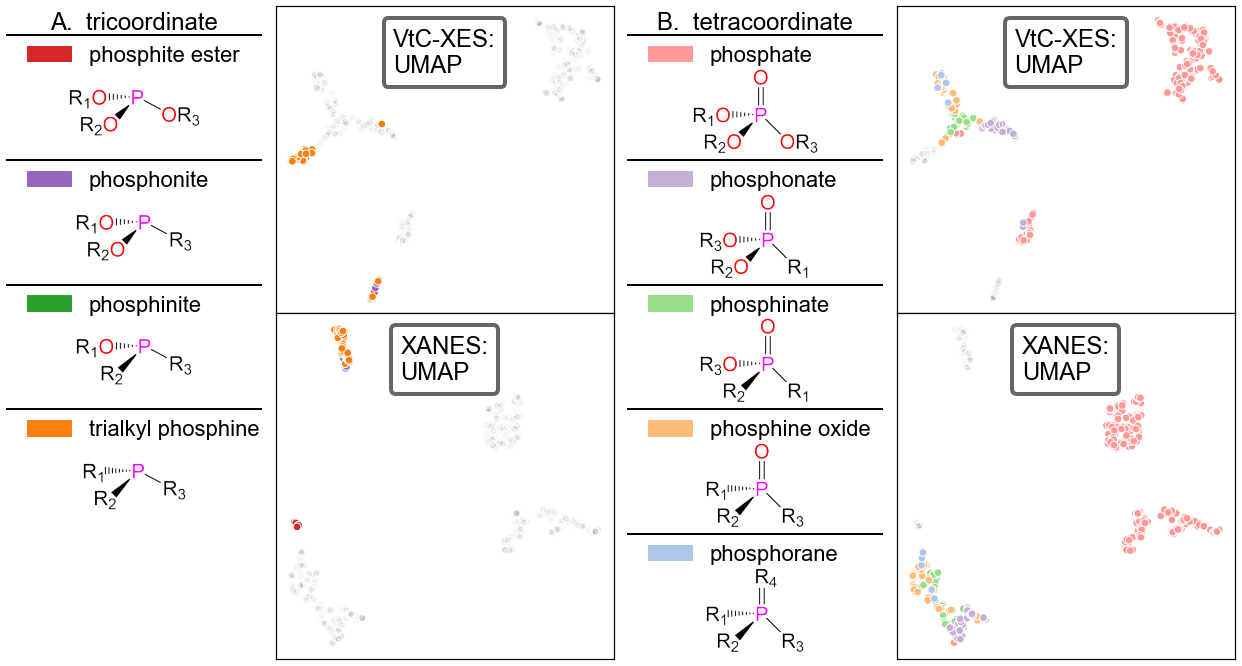

In [11]:
fig = plt.figure(figsize=(22,12))
asize = 0.3
spec = fig.add_gridspec(nrows=11, ncols=4,
                        width_ratios = [0.6, 0.8, 0.6, 0.8],
                        height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.05, hspace=0)

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate', 'B.  tetracoordinate']

colorcode, codemap = CLASSCODES, classcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # show structure
        structax = fig.add_subplot(spec[2*i + 2, 2*j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        plt.axis('equal')
        turn_off_ticks(structax)
        set_spine_width(structax, width=2)
        turn_off_spines(structax, spines=['top','left','right'])
        if i == len(structure_list) - 1:
            structax.spines['bottom'].set_visible(False)
        
        # make legend
        legax = fig.add_subplot(spec[2*i + 1, 2*j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.3),
                              fontsize=22, framealpha=0, frameon=False)
        turn_off_ticks(legax)
        set_spine_width(legax, width=2)
        turn_off_spines(legax, spines=['bottom','left','right'])
        
        if i == 0:
            legax.set_title(titles[j], fontsize=24)

for i, coordnum in enumerate([1, 3]):
    hiddencids = hiddenCIDS.copy()
    hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]
    ax = fig.add_subplot(spec[:6, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                                  mode='XES', method='UMAP', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03, **{'loc': 'upper center'})
    set_spine_width(ax, width=1.2)
    add_point_pubchem_link(class_tsneplt, X_coord)

    ax = fig.add_subplot(spec[6:11, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                                  mode='XANES', method='UMAP', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03, **{'loc': 'upper center'})
    set_spine_width(ax, width=1.2)
    add_point_pubchem_link(class_tsneplt, X_coord)
    
# plt.savefig(f'../Figures/oxidation.png', dpi=1000, transparent=False, bbox_inches='tight')

# Spaghetti based on chemical classes (within coordination)

* How do tricoordinate versus tetracoordinate compare spectrally?

In [12]:
if make_SI_figures:
    fig = plt.figure(figsize=(28,12))
    asize = 0.3
    spec = fig.add_gridspec(nrows=11, ncols=4,
                            width_ratios = [0.3, 0.7, 0.3, 0.7],
                            height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
    plt.subplots_adjust(wspace=0., hspace=0)

    tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
    tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

    tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
    tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

    structs = [tri_struct, tetra_struct]
    labels = [tri, tetra]
    titles = ['A.  tricoordinate', 'B.  tetracoordinate']

    colorcode, codemap = CLASSCODES, classcodemap

    for j, structure_list in enumerate(structs):
        for i, structure in enumerate(structure_list):
            # show structure
            structax = fig.add_subplot(spec[2*i + 2, 2*j])
            if j == 0:
                structure = resize_img(structure, ratio=(1,1.8))
            else:
                pass
            structax.imshow(structure)
            structax.axis('equal')
            turn_off_ticks(structax)
            turn_off_spines(structax)

            # make legend
            legax = fig.add_subplot(spec[2*i + 1, 2*j])
            patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                      label=(labels[j][i].replace('_',' ')))]
            legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.3),
                                  fontsize=22, framealpha=0, frameon=False)
            turn_off_ticks(legax)
            turn_off_spines(legax, spines=['bottom','left','right'])
            set_spine_width(legax, width=1.5)

            if i == 0:
                legax.set_title(titles[j], fontsize=24)

    for i, coordnum in enumerate([1, 3]):
        hiddencids = hiddenCIDS.copy()
        hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]

        binmap = {cid:v-1 for cid, v in classcodemap.items() if cid not in hiddencids}
        ax = fig.add_subplot(spec[:6, 2*i + 1])

        spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES',
                                       colorcodemap=binmap, binmap=binmap,
                                       fontsize=26, linewidth=4, scalecolor=False,
                                       hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                       verbose=False)

        ax = fig.add_subplot(spec[6:11, 2*i + 1])

        spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                                       colorcodemap=binmap, binmap=binmap,
                                       fontsize=26, linewidth=4, scalecolor=False,
                                       hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                       verbose=False, energyrange=(2142,2175))

    plt.savefig(f'../Figures/SI_oxidation_spaghetti.png', dpi=800, transparent=False, bbox_inches='tight')

## Sulfur-included bonding environment

* How does changing the ligand from carbon to sulfur impact the t-SNE clustering?

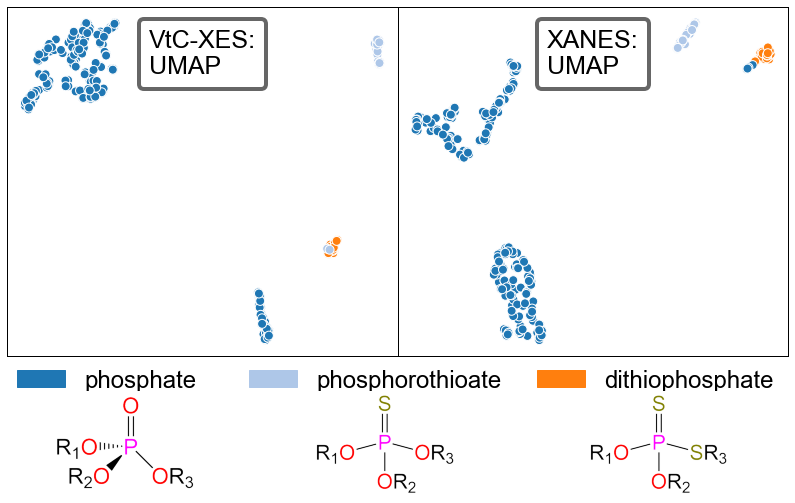

In [6]:
# sulfur subclasses
codemap = sulfurcodemap
labels = ['phosphate', 'phosphorothioate', 'dithiophosphate']
bin_names = list(SULFURCODES.keys())
N = len(labels)

fig = plt.figure(figsize=(14,9))
spec = fig.add_gridspec(nrows=3, ncols=6, width_ratios=[1, 0.8, 1.2, 1, 1, 1],
                        height_ratios=[1, 0.1, 0.3])
plt.subplots_adjust(wspace=0, hspace=0)

kwargs = {'Class': labels}

X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
                                                              perplexity=20, method='umap', **kwargs)
X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
                                                                  perplexity=18, method='umap', **kwargs)

structures = [plt.imread(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]

for i, structure in enumerate(structures):
    # make legend
    legax = fig.add_subplot(spec[1, 2*i:2*i + 2])
    patches = [mpatches.Patch(color=plt.cm.tab20(i), label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.3),
                              fontsize=24, framealpha=0, frameon=False)
    turn_off_ticks(legax)
    turn_off_spines(legax)

    # show structure
    structax = fig.add_subplot(spec[2, 2*i:2*i + 2])
    structax.imshow(structures[i])
    turn_off_ticks(structax)
    turn_off_spines(structax)

for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col1, col2 = 0, 3
        options = {'loc':'upper center'}
    else:
        tsnemap = XANES_tsnemap
        col1, col2 = 3, 6
        options = {'loc': 'upper center'}
    #################### tsne plot
    ax = fig.add_subplot(spec[0, col1:col2])
    tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap, size=80,
                            colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='UMAP', fontsize=25, edgecolors='w',
                            **Merge(kwargs, options))
    set_spine_width(ax, width=1.)
    add_point_pubchem_link(tsne_plt, X_subset)
    
# plt.savefig(f'../Figures/sulfur.png', dpi=1000, transparent=False, bbox_inches='tight')

## Phosphate subclusters

* Why are the phosphates being sub-divided into three different clusters?

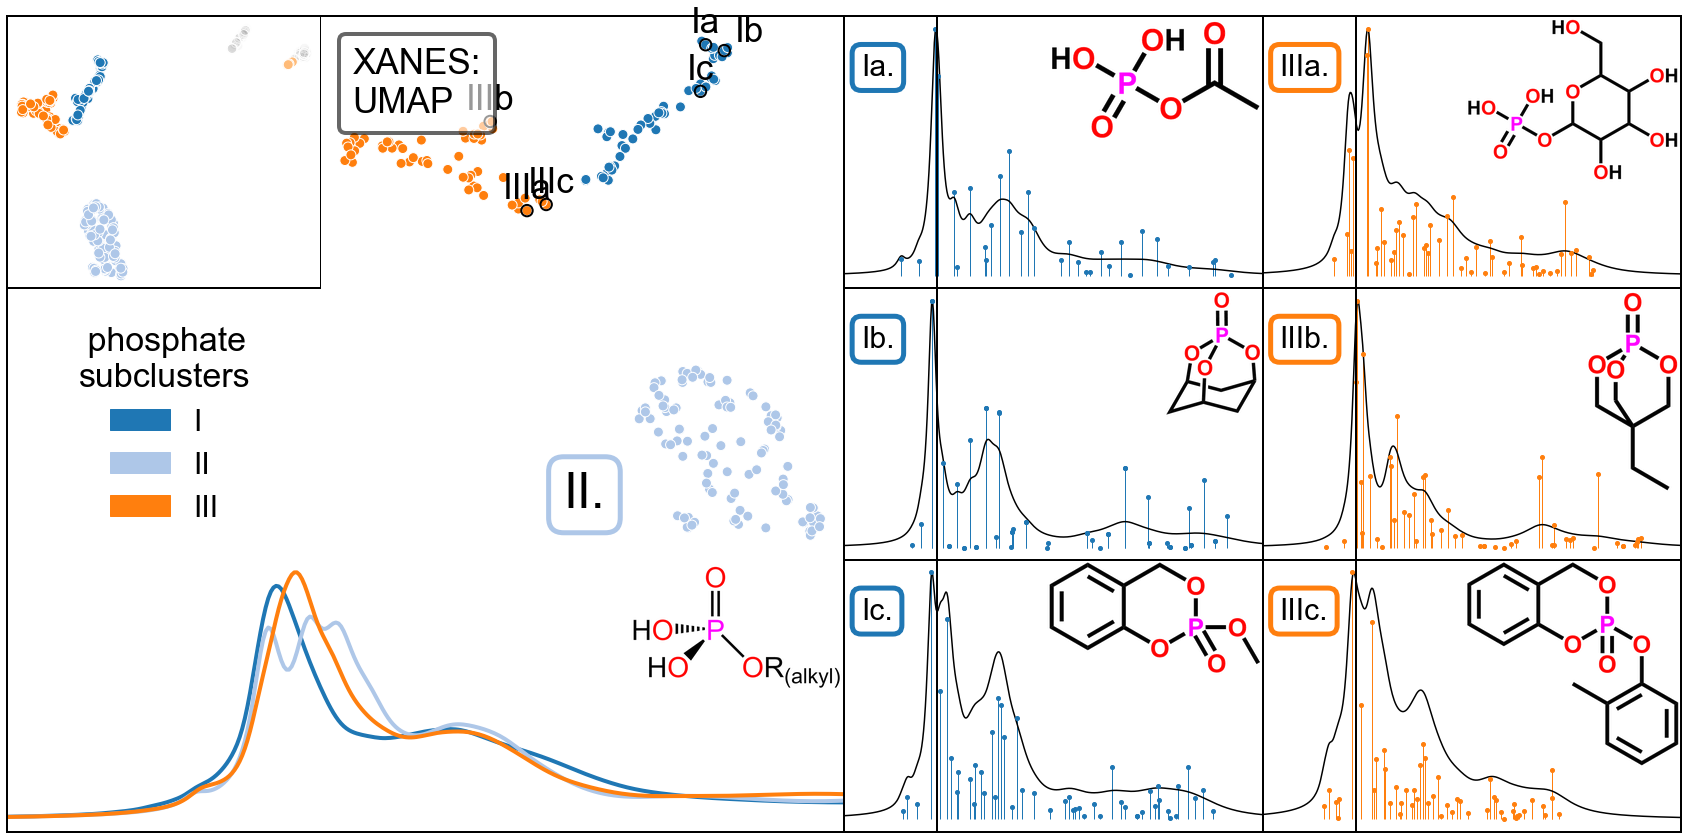

In [8]:
# kwargs options
kwargs = {'Class': ['phosphate'], 'loc':2, 'title': None}

# make figure
fig = plt.figure(figsize=(30,15))
spec = fig.add_gridspec(nrows=3, ncols=4, width_ratios=[0.6, 1.0, 0.8, 0.8])
plt.subplots_adjust(wspace=0, hspace=0)

############ create DBScan clusters
tsne_phosphates = np.array([XANES_tsnemap[c['CID']] for c in X_subset if c['Class'] == 'phosphate'])
cids_phosphates = [c['CID'] for c in X_subset if c['Class'] == 'phosphate']

dbscan_clustering = DBSCAN(eps=0.75, min_samples=1).fit(tsne_phosphates)
dbscan_clustermap = {cid:cluster for cid,cluster in zip(cids_phosphates, dbscan_clustering.labels_)}

############ plot all phosphates with clusters indicated by DBSCAN
phosphate_clustermap = {}
for c in X_subset:
    if c['Class'] == 'phosphate':
        phosphate_clustermap[c['CID']] = dbscan_clustermap[c['CID']] + 1
    else:
        phosphate_clustermap[c['CID']] = 0
              
select_clusters = np.unique(dbscan_clustering.labels_) + 1
select_clusters = select_clusters[:-1]
keys = {1:'I', 2:'II', 3:'III', 4:'IV', 5:'V', 6:'VI', 7:'VII'}

X_phosphate = [c for c in X_subset if phosphate_clustermap[c['CID']] in select_clusters]

phosphate_colorcodemap = {c['CID']:phosphate_clustermap[c['CID']] for c in X_subset \
                          if phosphate_clustermap[c['CID']] in select_clusters}
binmap = {k:v - 1 for k,v in phosphate_colorcodemap.items()}

# make legend
legax = fig.add_subplot(spec[1, 0])
patches = [mpatches.Patch(color=plt.cm.tab20(cluster - 1), label=keys[cluster])
           for cluster in select_clusters]
legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                      fontsize=30, framealpha=0, frameon=False,
                      title=' phosphate\nsubclusters', title_fontsize=34)
set_spine_width(legax, width=2)
turn_off_spines(legax, spines=['bottom', 'right'])
turn_off_ticks(legax)

# phosphate structure
structax = fig.add_subplot(spec[0, 0])
# structax.imshow(structure)
# structax.axis('equal')
# structure = Image.open(f'../Figures/chemdraw/phosphate.png')
# structure = resize_img(structure, ratio=(1,1.8))
tsne_plt = plot_dim_red((fig, structax), X_subset, XANES_tsnemap, size=100,
                        colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
                        mode='XANES', method='UMAP', fontsize=35, show_legend=False,
                        edgecolors='w', **kwargs)
# tsne_plt = plot_dim_red((fig, structax), X_subset, XANES_tsnemap, size=80,
#                          colorcodemap=sulfurcodemap, coloralpha=1., hiddenalpha=0.03,
#                          mode='XANES', method='UMAP', fontsize=25, edgecolors='w',
#                          show_legend=False)
set_spine_width(structax, width=2)
turn_off_ticks(structax)

######################### examples
cluster_cids = np.array([[186, 120825, 119401],[466, 13869, 104993]])

# example spectra
cluster_counts = [np.sum(dbscan_clustering.labels_ == cluster) for cluster in [0, 1, 2]]
show_clusters = np.delete([0, 1, 2], np.argmax(cluster_counts))

labels = [[f'{keys[show_clusters[0] + 1]}a.', f'{keys[show_clusters[0] + 1]}b.',\
           f'{keys[show_clusters[0] + 1]}c.'],\
          [f'{keys[show_clusters[1] + 1]}a.', f'{keys[show_clusters[1] + 1]}b.',\
           f'{keys[show_clusters[1] + 1]}c.']]
offsets = [(0, 5), (25, 2), (0, 5), (0, 5), (0, 5), (5, 5)]

# options = kwargs
options = Merge(kwargs, {'CID': cluster_cids.flatten(), 'offsets': offsets,
                         'label': [ele.replace('.', '') for sublist in labels
                                   for ele in sublist]})

############ zoomed in on clusters
ax = fig.add_subplot(spec[:2, 1])
tsne_plt = plot_dim_red((fig, ax), X_phosphate, XANES_tsnemap, size=100,
                        colorcodemap=phosphate_clustermap, hiddenalpha=0.03,
                        mode='XANES', method='UMAP', fontsize=35,
                        edgecolors='w', **options)
set_spine_width(ax, width=2)
turn_off_spines(ax, spines=['bottom', 'left'])
# add_point_pubchem_link(tsne_plt, X_phosphate)

############ spaghetti plot of average clusters indicated by DBSCAN
ax = fig.add_subplot(spec[2, :2])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                               colorcodemap=binmap, binmap=binmap, fontsize=26,
                               linewidth=4, energyrange=(2148,2162.5), scalecolor=False,
                               hiddenalpha=0, coloralpha=1.0, average_bins=True,
                               **kwargs)
## adding cluster II structure
add_structure(fig, 'II', ax, resize=False, add_axes=True, chemdraw=True)
t = ax.text(2158, 0.43, 'II.', ha="center", va="center", size=50,
            bbox=dict(boxstyle="round,pad=0.3", ec=plt.cm.tab20(1), fc="w", lw=5))

# formatting axis
set_spine_width(ax, width=2)
turn_off_ticks(ax)
ax.set_xlabel(None)
turn_off_spines(ax, spines=['top'])

for j, cid_list in enumerate(cluster_cids):
    cluster = show_clusters[j]
    for i, cid in enumerate(cid_list):
        if i == 3:
            verbose = False
        else:
            verbose = False
        
        ax = fig.add_subplot(spec[i, j + 2])
        plot_spectrum_and_trans((fig, ax), compoundmap, cid, verbose=verbose,
                                mode='XANES', energyrange=(2148,2169), color=cluster,
                                link_pubchem=True, chemdraw=True, label=labels[j][i])
        set_spine_width(ax, width=2)
        turn_off_ticks(ax)
    
# plt.savefig(f'../Figures/phosphate_subclusters.png', dpi=800, transparent=False, bbox_inches='tight')

### Generate examples

[[  62773  439871 6107844   21804    3039]
 [   7925    6535   17280    4420   81525]]
[[ 3034794   439452   439276    74188   439162]
 [    1055     1051 21896400      561 45934311]]
[[      59   160886     2526   439278    83430]
 [  439236   440043     1005    99058 44610740]]
[[ 12691406  12691392]
 [118796916 102571803]]


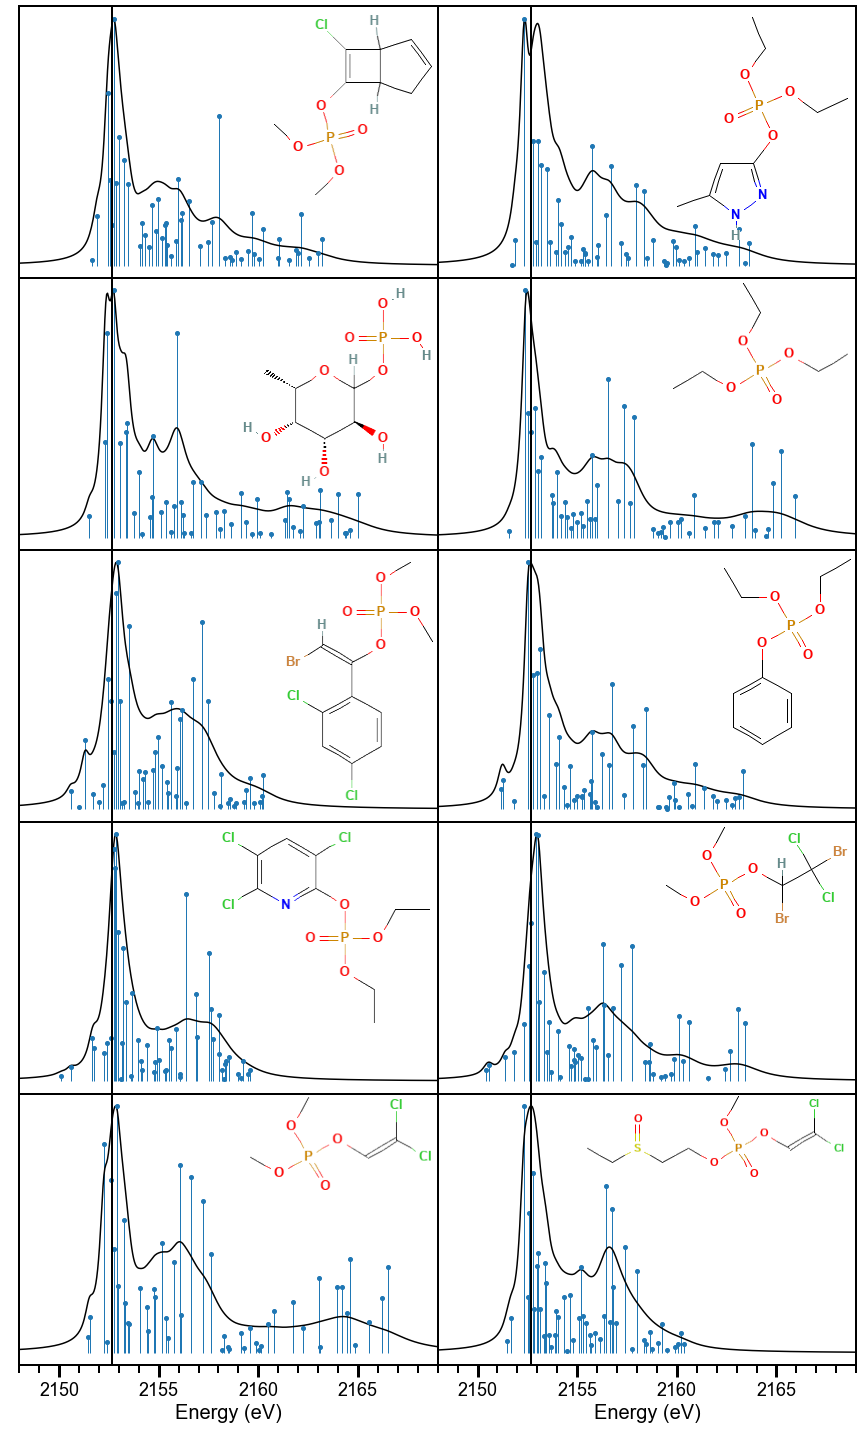

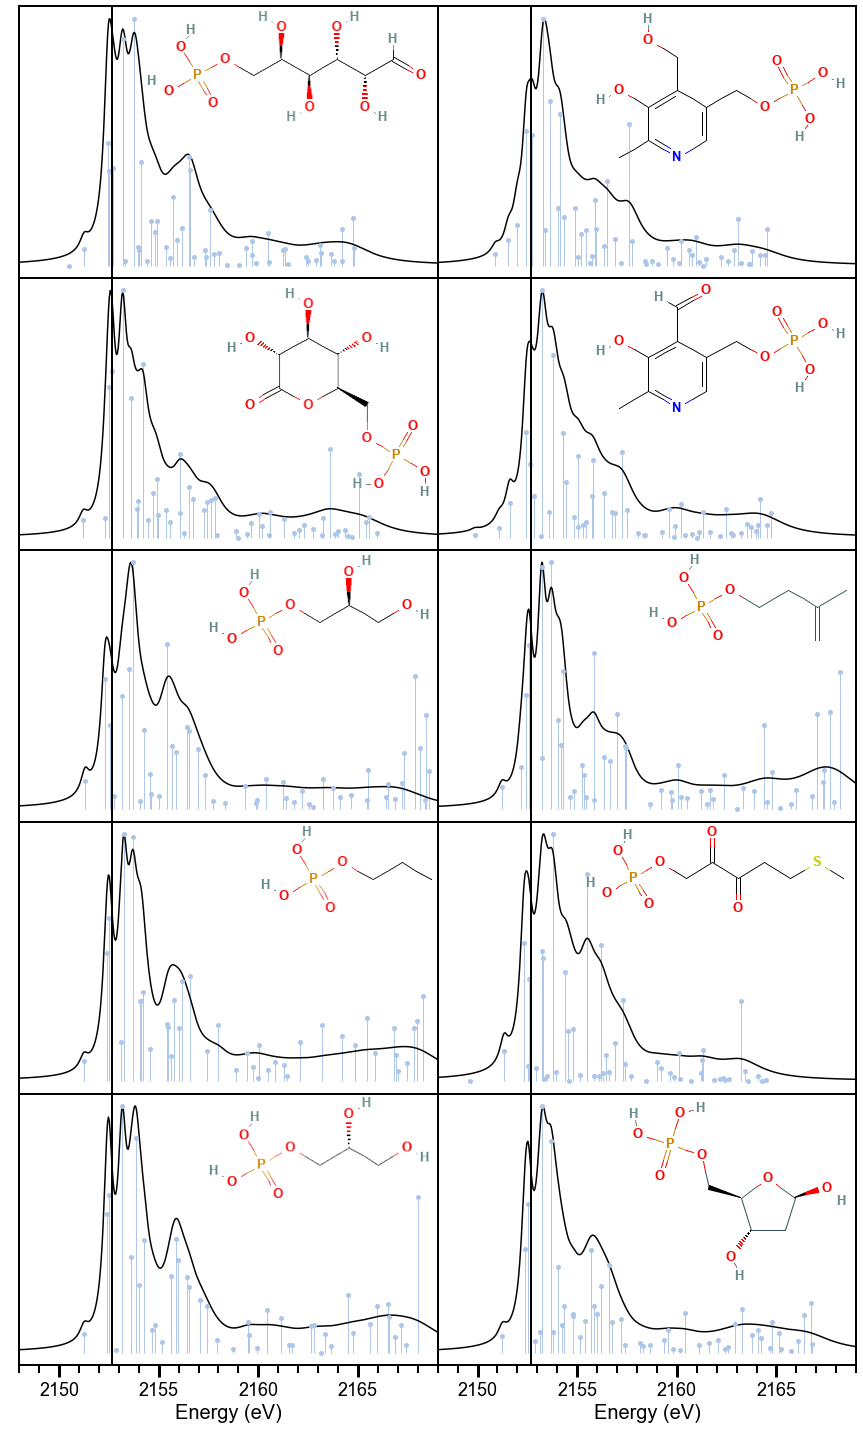

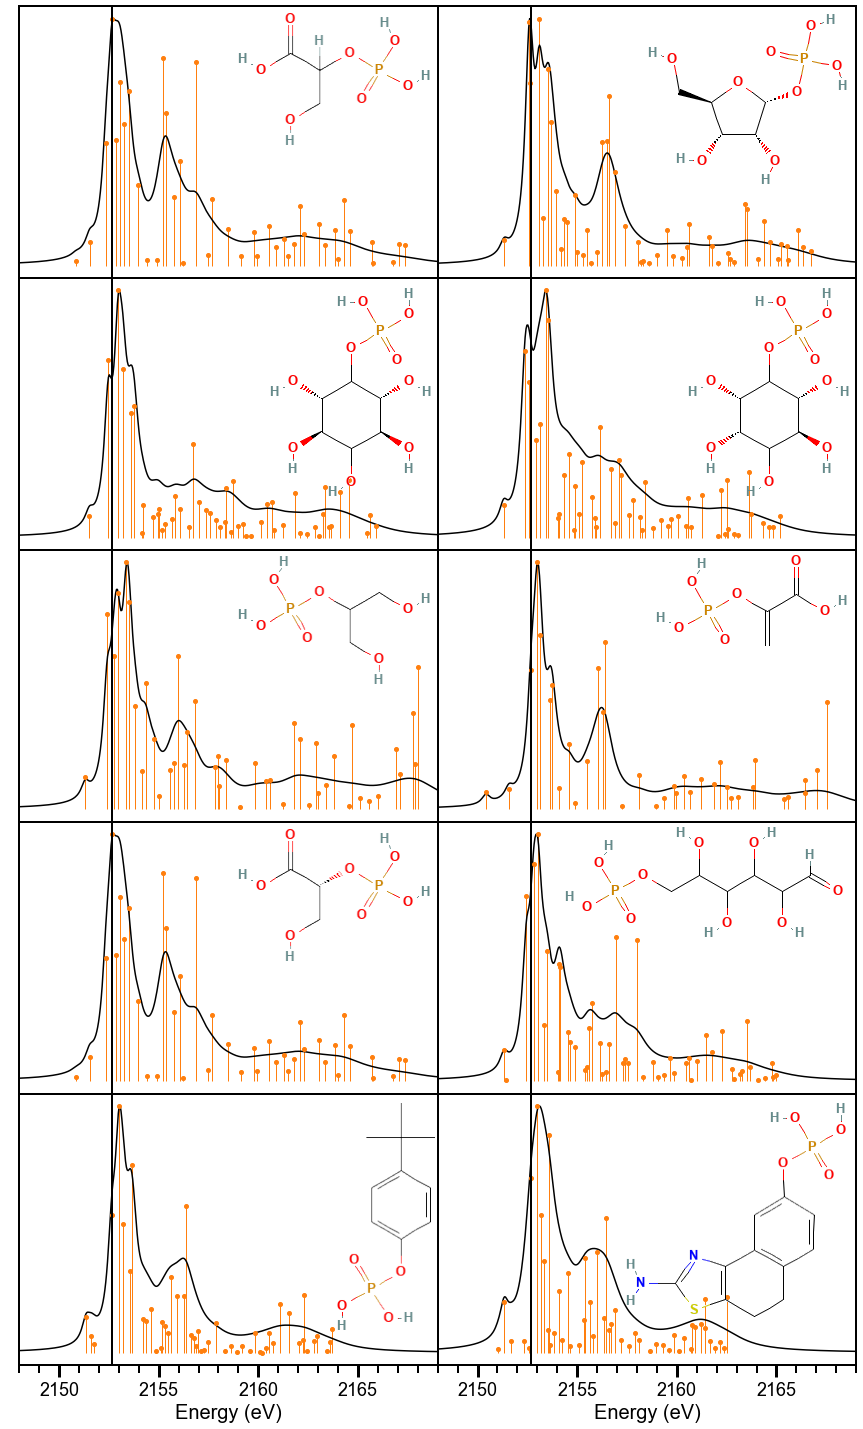

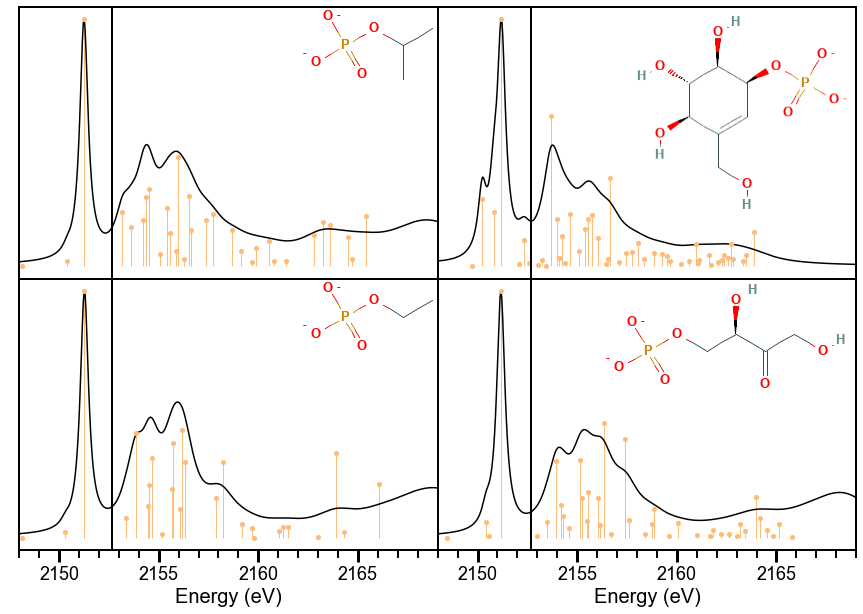

In [9]:
if True:
    for select in [0, 1, 2, 3]:
        cids = []
        for cid, cluster in dbscan_clustermap.items():
            if cluster == select and cid not in cluster_cids:
                cids += [cid]

        if len(cids) < 10:
            N = len(cids)//2
        else:
            N = 5
        cids = np.array(cids[:N*2]).reshape((2,N))
        print(cids)

        fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(15,N*5))
        plt.subplots_adjust(wspace=0, hspace=0)

        for cluster, cid_list in enumerate(cids):
            for i, cid in enumerate(cid_list):
                if i == N-1:
                    verbose = True
                else:
                    verbose = False
                plot_spectrum_and_trans((fig, axes[i, cluster]), compoundmap, cid, verbose=verbose,
                                        mode='XANES', energyrange=(2148,2169), color=select,
                                        link_pubchem=True, chemdraw=False, resize=True)
                set_spine_width(axes[i, cluster], width=2)
        plt.savefig(f'../Figures/SI_phosphate_cluster_{select + 1}.png', dpi=800, bbox_inches='tight')

### Charge analysis

In [19]:
if make_SI_figures:
    coord_to_charge_map = {}
    cids = []
    for i in range(len(X_phosphate)):
        cid = X_phosphate[i]['CID']
        data = parse_esp_file(cid)
        if data is not None:
            cids.append(cid)
            coord_to_charge_map[cid] = data

    cid = cids[0]
    print(cid)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    points, colors, sizes, labels = get_plot_data(coord_to_charge_map[cid])
    dots = ax.scatter(*zip(*points), s=sizes, c=colors, label=labels)
    ax.set_title(cid, fontsize=20)
    add_charge_label(dots, coord_to_charge_map[cid])

    make_charge_hist(plt.subplots(figsize=(12,6)), oxygen_chargemap,
                     colorcodemap=phosphate_clustermap,
                     bins=25, atom='O', fontsize=20)
    plt.savefig(f'../Figures/SI_O_charge_hist.png', dpi=800, bbox_inches='tight')

# OH group dependence

* How do hydroxyls, i.e., an H instead of a C, impact the spectra?

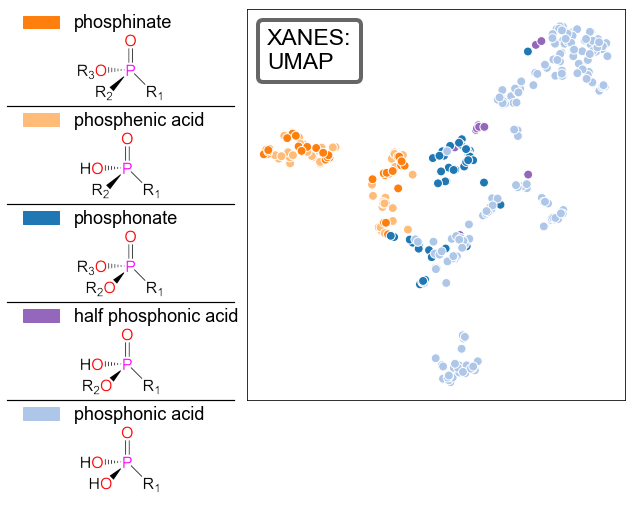

In [16]:
labels = ['phosphinate', 'phosphenic_acid', 'phosphonate', 'half_phosphonic_acid', 'phosphonic_acid']
structures = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]
colorcode, codemap = OHCODES, ohcodemap
N = len(labels)

method = 'UMAP'

########## set up figure with axes
fig = plt.figure(figsize=(14, 9))
ratio = 0.3
spec = fig.add_gridspec(nrows=N*2, ncols=3, width_ratios=[0.6, 1, 0.4],
                        height_ratios=[ratio, 1, ratio, 1, ratio, 1, ratio, 1, ratio, 1])
plt.subplots_adjust(wspace=0.05, hspace=0)

########## set up formatting kwargs and variables
kwargs = {'Class': labels, 'loc':1, 'title': ''}

########## get reuced spaces with corresponding maps
X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
                                                              method=method, **kwargs)
X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
                                                                  method=method, **kwargs)
cid_subset = [c['CID'] for c in X_data_classed if c['Class'] in labels]

########## make first column with structures
for i, structure in enumerate(structures):
    # show structure
    structax = fig.add_subplot(spec[2*i+1,0])
    structax.imshow(structures[i])
    structax.axis('equal')
    # Hide spines
    turn_off_spines(structax)
    turn_off_ticks(structax)
        
    # make legend
    legax = fig.add_subplot(spec[2*i,0])
    patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[i]] - 1),
                              label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.35),
                          fontsize=18, framealpha=0, frameon=False)
    # Hide spines
    set_spine_width(legax, width=1.2)
    turn_off_spines(legax, spines=['bottom','left','right'])
    if i == 0:
        turn_off_spines(legax, spines=['top'])
    turn_off_ticks(legax)
    
########### set-up example settings
select_cids = [98611, 21720419, 104467]
label = ['a', 'b', 'c']
colorcodemap = {98611:0.1, 21720419:0.5, 104467:0.7} 
offsets = [(-18, -14), (15, -5), (3, 5)]
energyrange = (2119, 2142)
tsnemap = XES_tsnemap   

###### spaghetti plot of selected cids
ax = fig.add_subplot(spec[N*2-2:, 1])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES', scalecolor=False,
                                colorcodemap=colorcodemap, colormap=plt.cm.viridis,
                                linewidth=2.5, hiddenalpha=0, coloralpha=1.0, verbose=False,
                                energyrange=energyrange, **Merge(kwargs, options))

###### drawing arrow and annotating
x, y, dx, dy = 2132.5, 1.18, 1.8, -0.13
arr = mpl.patches.Arrow(x, y, dx, dy, width=0.04, linestyle='-',
                        edgecolor='k', facecolor='k', zorder=5)
ax.add_patch(arr)
ax.annotate('a', (x, y), ha='center', va='bottom',
            size=24, xytext=(-10, 2), textcoords='offset points')
ax.annotate('c', (x + dx, y + dy), ha='center', va='bottom',
            size=24, xytext=(10, -10), textcoords='offset points')

######## select options for the 2D plot
options = Merge(kwargs, {'CID': select_cids, 'offsets':offsets, 'label':label})
subax = fig.add_subplot(spec[:N*2-2, 1])
            
#################### tsne plot   
tsne_plt = plot_dim_red((fig, subax), X_subset, tsnemap, size=80, 
                        colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                        mode='XES', method=method, fontsize=23, edgecolors='w',
                        large_ticks=False, **options)

##### show selected cid structures
for i, cid in enumerate(select_cids):
    size = 2
    structax = fig.add_subplot(spec[size*i*2: size*i*2 + size, 2])
    img = Image.open(f"../Figures/chemdraw/{cid}.png")
    structax.imshow(img)
    structax.axis('off')
    structax.annotate(label[i], (0, 0), ha='right', va='top',
                      size=24, xytext=(-0.35, 0.9), textcoords='axes fraction')
        
# plt.savefig(f'../Figures/{method}_OH.png', dpi=1000, transparent=False, bbox_inches='tight')

# Supervised ML Visualization

In [20]:
utils = reload(utils)
from utils import *

In [13]:
# coordination
real_coord_map = {1: 3, 3: 4} # from color to coord number
real_coordination_codemap = {c['CID']:real_coord_map[coordcodemap[c['CID']]] for c in X_coord}

In [14]:
Accuracies = [[], []]
Confidence = [[], []]

Schemes = ['Coordination', 'Oxygens', 'Phosphates', 'Sulfur ligand', 'Hydroxyl ligand']
codemaps = [real_coordination_codemap, classcodemap, phosphate_colorcodemap,
            sulfurcodemap, ohcodemap]
test_files = ['coord_test_cids.txt', 'oxy_test_cids.txt', 'phosphate_test_cids.txt',
              'sulfur_test_cids.txt', 'OH_test_cids.txt']
CODEMAPS = [COORDCODES, CLASSCODES, {'phosphate':1}, SULFURCODES, OHCODES]

kwargs = {'method': 'UMAP', 'ndim': 5}

for codemap, test_file, scheme, CODES in zip(codemaps, test_files, Schemes, CODEMAPS):
    test_map = get_test_map(test_file)
    kwargs['codemap'] = codemap
    kwargs['Class'] = list(CODES.keys())
    train_map = get_train_map(codemap, test_map)
    train_GP(X_data_classed, train_map, test_map, Accuracies=Accuracies,
             Confidence=Confidence, validate=False, **kwargs)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklear

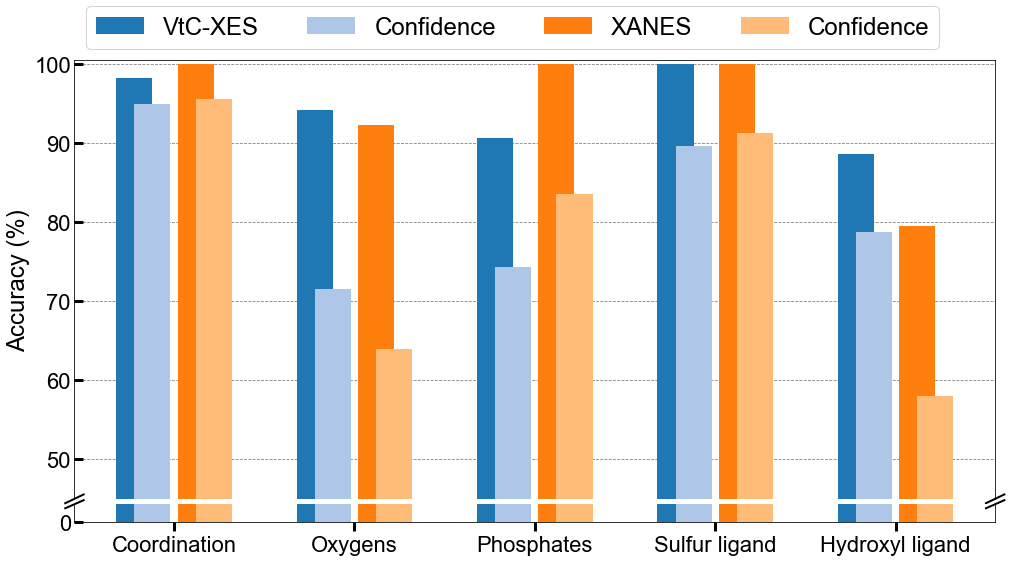

In [21]:
bar_chart(Accuracies, Confidence, Schemes, save=True)